In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('large_repr', 'truncate')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.grid(b=None)
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set()
#sns.set_palette("Paired")


from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from typing import Tuple

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
DATA_PATH = Path("../data/")
DOCUMENTATION_PATH = Path("../documentation")
RANDOM_STATE_PARAMETER = 42
TEST_SIZE = .25

# APLD patients

In [7]:
data = pd.read_csv(DATA_PATH / "apld_patients.csv")
data.reset_index(inplace=True)
data.drop(["BC_PATIENT", "SN_PATIENT", "DIAGNOSIS_CODE", "index"], axis=1, inplace=True)
data.rename(columns={"SERVICE_DATE_y": "Service_date", "SEASON": "Season"}, inplace=True)
cols = ['PATIENT_ID',
 'Service_date',
 'Season',
 'PRC_STD_CD',
 'Blood',
 'Bone',
 'Breast',
 'Heart',
 'Lungs',
 'Medication',
 'Medication ',
 'Other',
 'Skin',
 'Stomach',
 'Vagina',
  'mBC_PATIENT']
data = data[cols]

,PATIENT_ID,Service_date,Season,PRC_STD_CD,Blood,Bone,Breast,Heart,Lungs,Medication,Medication,Other,Skin,Stomach,Vagina,mBC_PATIENT
0,134290358,10/15/2015,4,99214,0,0,0,0,0,0,0,1,0,0,0,True
1,134290358,10/15/2015,4,99214,0,0,0,0,0,0,0,1,0,0,0,True
2,134290358,10/15/2015,4,99214,0,0,0,0,0,0,0,1,0,0,0,True
3,1057559593,11/25/2015,4,85025,0,0,0,0,0,0,0,1,0,0,0,True
4,1057559593,11/25/2015,4,36415,0,0,0,0,0,0,0,1,0,0,0,True
5,1057559593,11/25/2015,4,86850,0,0,0,0,0,0,0,1,0,0,0,True
6,1057559593,11/25/2015,4,86900,0,0,0,0,0,0,0,1,0,0,0,True
7,1057559593,11/25/2015,4,J0690,0,0,0,0,0,0,0,1,0,0,0,True
8,1057559593,11/25/2015,4,J2250,0,0,0,0,0,0,0,1,0,0,0,True
9,1057559593,11/25/2015,4,86901,0,0,0,0,0,0,0,1,0,0,0,True


In [7]:
data.dtypes

PATIENT_ID       int64
Service_date    object
Season           int64
PRC_STD_CD      object
Blood            int64
Bone             int64
Breast           int64
Heart            int64
Lungs            int64
Medication       int64
Medication       int64
Other            int64
Skin             int64
Stomach          int64
Vagina           int64
mBC_PATIENT       bool
dtype: object

In [8]:
data.describe()

,PATIENT_ID,Season,Blood,Bone,Breast,Heart,Lungs,Medication,Medication,Other,Skin,Stomach,Vagina
count,164210.000,164210.000,164210.000,164210.000,164210.000,164210.000,164210.000,164210.000,164210.000,164210.000,164210.000,164210.000,164210.000
mean,498022762.282,2.586,0.000,0.000,0.000,0.000,0.000,0.022,0.000,0.976,0.000,0.001,0.000
std,513351735.806,1.212,0.019,0.014,0.016,0.007,0.004,0.147,0.000,0.152,0.011,0.024,0.002
min,29544598.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,75599986.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
50%,299267531.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
75%,796085758.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
max,1733916397.000,4.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000


In [9]:
# checking missing data in data 
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
mBC_PATIENT,0,0.000
Vagina,0,0.000
Stomach,0,0.000
Skin,0,0.000
Other,0,0.000


In [10]:
data.Medication.unique()

array([0, 1])

In [11]:
unique_patients = data.drop_duplicates('PATIENT_ID')
non_mbc_patients = unique_patients[~unique_patients["mBC_PATIENT"]]

In [12]:
mbc_patients = unique_patients[unique_patients["mBC_PATIENT"]]

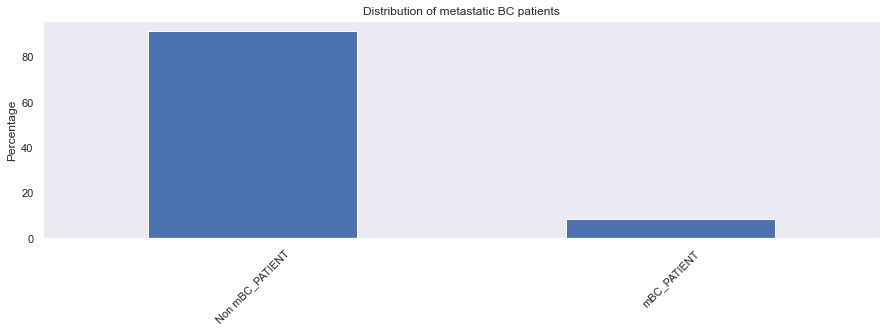

In [13]:
plt.figure(figsize=(15,4))
plt.ticklabel_format(style='plain', axis='y')
(unique_patients['mBC_PATIENT'].value_counts()/ len(unique_patients) * 100).plot.bar();
plt.ylabel('Percentage', fontsize = 12)
plt.xticks([0,1], ["Non mBC_PATIENT", "mBC_PATIENT"], rotation=45)
plt.title("Distribution of metastatic BC patients")
plt.savefig("mBC_patients_percentage_distributions.pdf")
plt.grid(b=None)
plt.show()
plt.close()

In [14]:
prop_mbc_patients = len(non_mbc_patients)/len(mbc_patients)
print(f"Proportion of mBC patients:{prop_mbc_patients * 100.0}%")

Proportion of mBC patients:9.411764705882353%


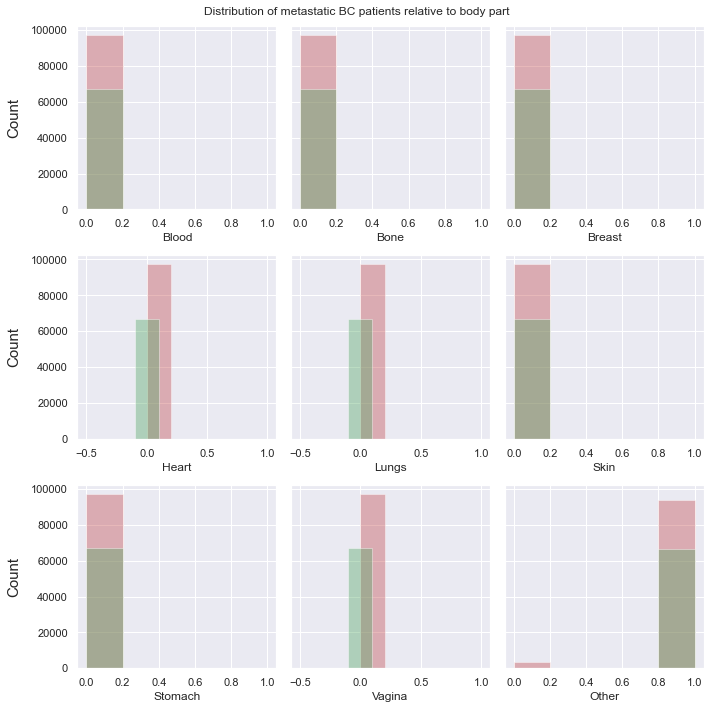

In [15]:
cols_to_apply = ['Blood', 'Bone', 'Breast', 'Heart', 'Lungs', "Skin", 'Stomach', 'Vagina', "Other"]
n_columns = len(cols_to_apply)
fig, axs = plt.subplots(3, 3, figsize=(10,10), sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.flat
for ax_index, column in enumerate(cols_to_apply):
    sns.distplot(data[data.mBC_PATIENT==True][column], hist=True, kde=False, color='r', bins=5, ax=axs[ax_index])    
    sns.distplot(data[data.mBC_PATIENT==False][column], hist=True, kde=False, color='g',
                 bins=5, ax=axs[ax_index])
    if ax_index % 3 == 0:
        axs[ax_index].set_ylabel("Count", fontsize=15, labelpad=10)
fig.suptitle("Distribution of metastatic BC patients relative to body part")

plt.gcf().subplots_adjust(bottom=0.3)
plt.gcf().subplots_adjust(left=0.3)
plt.tight_layout()    
plt.savefig("body_part_mBC_plot.pdf")
plt.show()
plt.close()

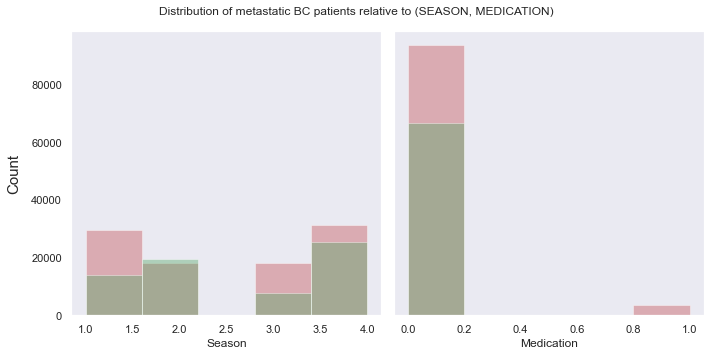

In [16]:
cols_to_apply = ['Season', 'Medication']
n_columns = len(cols_to_apply)
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.flat
nb_bins = 5
for ax_index, column in enumerate(cols_to_apply):
    sns.distplot(data[data.mBC_PATIENT==True][column], hist=True, kde=False, color='r', bins=nb_bins, ax=axs[ax_index])    
    sns.distplot(data[data.mBC_PATIENT==False][column], hist=True, kde=False, color='g',
                 bins=nb_bins, ax=axs[ax_index])
    axs[ax_index].grid(False)
    if ax_index % 3 == 0:
        axs[ax_index].set_ylabel("Count", fontsize=15, labelpad=10)
fig.suptitle("Distribution of metastatic BC patients relative to (SEASON, MEDICATION)")

plt.gcf().subplots_adjust(bottom=0.3)
plt.gcf().subplots_adjust(left=0.3)
plt.tight_layout()    
plt.savefig("season_medication_mBC_plot.pdf")
plt.show()
plt.close()

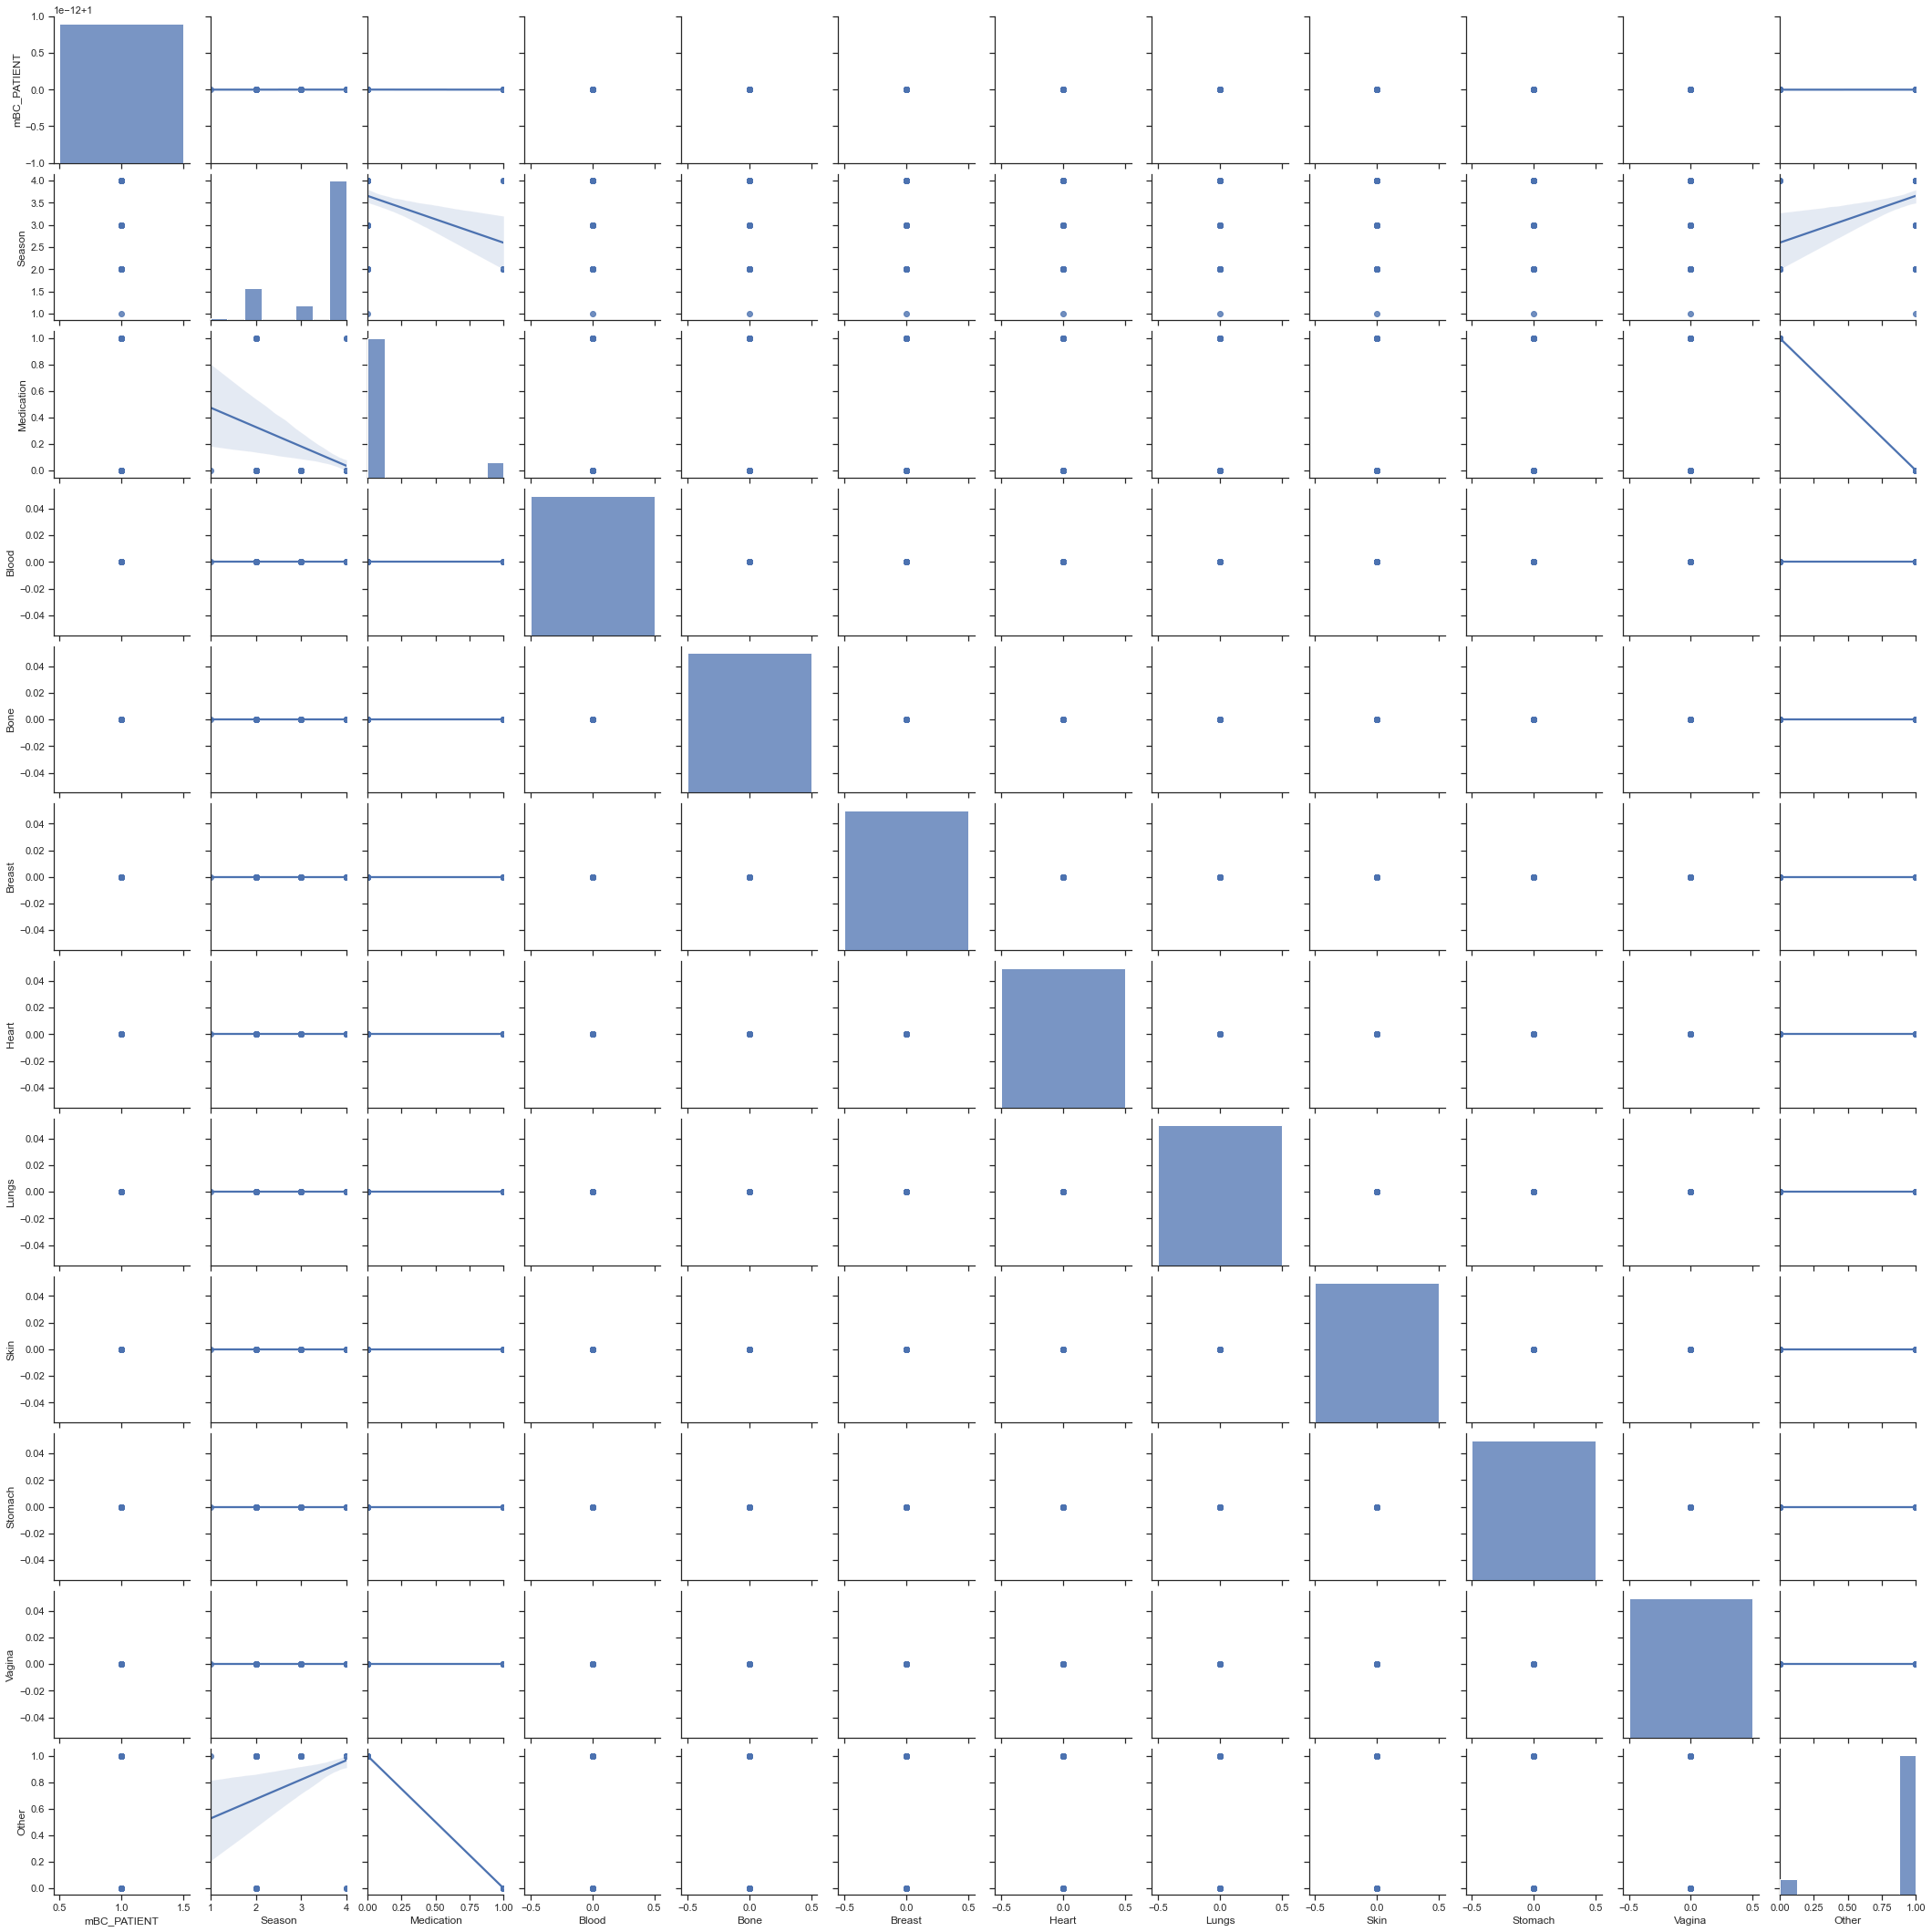

In [113]:
cols_to_apply = ["mBC_PATIENT", 'Season', 'Medication', 'Blood', 'Bone', 'Breast', 'Heart', 'Lungs', "Skin", 'Stomach', 'Vagina', "Other"]
small_dataset = data.iloc[:100, :][cols_to_apply]
#sns.set(style="ticks", color_codes=True)
sns.pairplot(small_dataset, kind="reg")
plt.savefig("pair_plot_reg.pdf")
plt.show()
plt.close()